#### Companion notebook for Alphalens tutorial lesson 2

# Creating Tear Sheets With Alphalens

In the previous lesson, you learned what Alphalens is. In this lesson, you will learn a four step process for how to use it:

1. Express an alpha factor and define a trading universe by creating and running a Pipeline over a certain time period.
2. Query pricing data for the assets in our universe during that same time period with `get_pricing()`.
3. Align the alpha factor data with the pricing data with `get_clean_factor_and_forward_returns()`.
4. Visualize how well our alpha factor predicts future price movements with `create_full_tear_sheet()`.

## Build And Run A Pipeline
Execute the following code to express an alpha factor based on asset growth, then run it with `run_pipeline()`

In [1]:
from quantopian.pipeline import Pipeline,CustomFactor
from quantopian.pipeline.data import factset,EquityPricing,Fundamentals
from quantopian.pipeline.factors import SimpleMovingAverage,Returns
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.pipeline.data.psychsignal import stocktwits
import datetime
import quantopian.pipeline.data.factset.estimates as fe
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  


In [2]:

class Momentum(CustomFactor):
    # will give us the returns from last month
    inputs = [Returns(window_length=20)]
    window_length = 20
    
    def compute(self, today, assets, out, lag_returns):
        out[:] = lag_returns[0]
            
class Volatility(CustomFactor):  
    inputs = [USEquityPricing.close]  
    window_length = 20  
    def compute(self, today, assets, out, close):  
        # [0:-1] is needed to remove last close since diff is one element shorter  
        daily_returns = np.diff(close, axis = 0) / close[0:-1]  
        out[:] = daily_returns.std(axis = 0) * math.sqrt(252)

      

            
def create_factor():
    # Base universe set to the QTradableStocksUS
    CumulativeMomentum = Momentum()
    
    ten_day_momentum = Momentum(window_length=10)
    std_dev = Volatility()
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    qtu = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    std_dev_winsorized = std_dev.winsorize(min_percentile=0.05, max_percentile=0.95)
    CumulativeMomentum_winzorized = CumulativeMomentum.winsorize(min_percentile=0.05, max_percentile=0.95)
    ten_day_momentum_winsorized = ten_day_momentum.winsorize(min_percentile=0.05, max_percentile=0.95)
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )

    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    #
    BuiltFact = CumulativeMomentum_winzorized.zscore() + value_winsorized.zscore() + quality_winsorized.zscore() + sentiment_score_winsorized.zscore() + ten_day_momentum_winsorized.zscore() + std_dev_winsorized.zscore()
    
    if( std_dev_winsorized.zscore() > 0 ):
        BuiltFact = (BuiltFact)/(1+std_dev_winsorized.zscore())
    else:
        BuiltFact = (BuiltFact)*(1-std_dev_winsorized.zscore())
    
    alpha_factor = (
        BuiltFact
    )
    return alpha_factor, qtu
 
    
    
def make_pipeline():  
    alpha_factor, qtu = create_factor()
    
    
    screenAlpha = qtu & ~alpha_factor.isnull() & alpha_factor.isfinite()
    
    # Winsorize to remove extreme outliers
    alpha_winsorized = alpha_factor.winsorize(min_percentile=0.01,
                                              max_percentile=0.99,
                                              mask=screenAlpha)
    
    # Zscore and rank to get long and short (positive and negative) alphas to use as weights
    alpha_rank = alpha_winsorized.rank().zscore()
    
    return Pipeline(columns={'alpha_factor': alpha_rank}, 
                    screen=qtu, domain=US_EQUITIES)
    
pipeline_output = run_pipeline(pipeline=make_pipeline(), start_date='2018-04-29', end_date='2020-04-29')

# Show the first 5 rows of factor_data
pipeline_output.head(5) 

alpha_factor
2018-04-30 00:00:00+00:00 Equity(2 [HWM])       -1.222210
                          Equity(24 [AAPL])      0.267689
                          Equity(31 [ABAX])      0.146172
                          Equity(41 [ARCB])     -0.283539
                          Equity(52 [ABM])      -1.523360

## Query Pricing Data

Now that we have factor data, let's get pricing data for the same time period. `get_pricing()` returns pricing data for a list of assets over a specified time period. It requires four arguments:
- A list of assets for which we want pricing.
- A start date
- An end date
- Whether to use open, high, low or close pricing.

Execute the following cell to get pricing data.

In [5]:
pricing_data = get_pricing(
    symbols=pipeline_output.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
    start_date='2018-04-29',
    end_date='2020-04-29', # must be after run_pipeline()'s end date. Explained more in lesson 4
    fields='open_price' # Generally, you should use open pricing.
)

# Show the first 5 rows of pricing_data
pricing_data.head(5)

,Equity(2 [HWM]),Equity(21 [AAME]),Equity(24 [AAPL]),Equity(25 [HWM_PR]),Equity(31 [ABAX]),Equity(39 [DDC]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),...,Equity(54105 [BKIE]),Equity(54106 [BKEM]),Equity(54107 [BKAG]),Equity(54108 [BKSB]),Equity(54109 [BKHY]),Equity(54110 [ORIC]),Equity(54111 [CHAQ_U]),Equity(54112 [PCPL_U]),Equity(54113 [FEAC]),Equity(54114 [FEAC_WS])
2018-04-30 00:00:00+00:00,19.977,3.224,157.635,NaN,66.366,NaN,32.129,30.073,303.28,57.793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 00:00:00+00:00,17.732,NaN,161.797,83.923,66.476,NaN,31.441,29.709,301.69,55.800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-02 00:00:00+00:00,17.525,3.150,170.367,NaN,67.175,NaN,31.344,29.316,309.77,56.564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-03 00:00:00+00:00,17.043,NaN,171.004,NaN,66.865,NaN,32.030,29.154,310.00,55.887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 00:00:00+00:00,16.697,NaN,173.308,82.391,66.636,NaN,32.962,28.867,335.52,55.742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Align Data

`get_clean_factor_and_forward_returns()` aligns the factor data created by `run_pipeline()` with the pricing data created by `get_pricing()`, and returns an object suitable for analysis with Alphalens' charting functions. It requires two arguments:
- The factor data we created with `run_pipeline()`.
- The pricing data we created with `get_pricing()`.

Execute the following cell to align the factor data with the pricing data.

In [6]:
from alphalens.utils import get_clean_factor_and_forward_returns

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output, 
    prices=pricing_data
)

# Show the first 5 rows of merged_data
factor_data.head(5) 

Dropped 12.8% entries from factor data: 12.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                             
2018-04-30 00:00:00+00:00 Equity(2 [HWM])   -0.112379 -0.148871 -0.097913   
                          Equity(24 [AAPL])  0.026403  0.142170  0.170292   
                          Equity(31 [ABAX])  0.001657  0.047826  0.066766   
                          Equity(41 [ARCB]) -0.021414  0.036634  0.449749   
                          Equity(52 [ABM])  -0.012104 -0.033419 -0.029295   

                                               factor  factor_quantile  
date                      asset                                         
2018-04-30 00:00:00+00:00 Equity(2 [HWM])   -1.222210                1  
                          Equity(24 [AAPL])  0.267689                3  
                          Equity(31 [ABAX])  0.146172                3  
                          Equity(41 [ARCB]) -0.283539                3  
                          Equity(52 [ABM])  -1.523360                1

## Visualize Results

Finally, execute the following cell to pass the output of `get_clean_factor_and_forward_returns()` to a function called `create_full_tear_sheet()`. This will create whats known as a tear sheet.

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.731192,-1.032131,-1.384157,0.200290,191959,20.022238
2,-1.040812,-0.340403,-0.691634,0.199687,191635,19.988443
3,-0.350231,0.350795,0.000059,0.199682,191652,19.990216
4,0.340029,1.041518,0.691697,0.199711,191635,19.988443
5,1.031026,1.731191,1.384120,0.200176,191848,20.010660


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.002,-0.003,0.004
beta,-0.115,-0.113,-0.088
Mean Period Wise Return Top Quantile (bps),0.224,0.223,0.815
Mean Period Wise Return Bottom Quantile (bps),0.323,-0.008,0.070
Mean Period Wise Spread (bps),-0.099,0.119,0.686


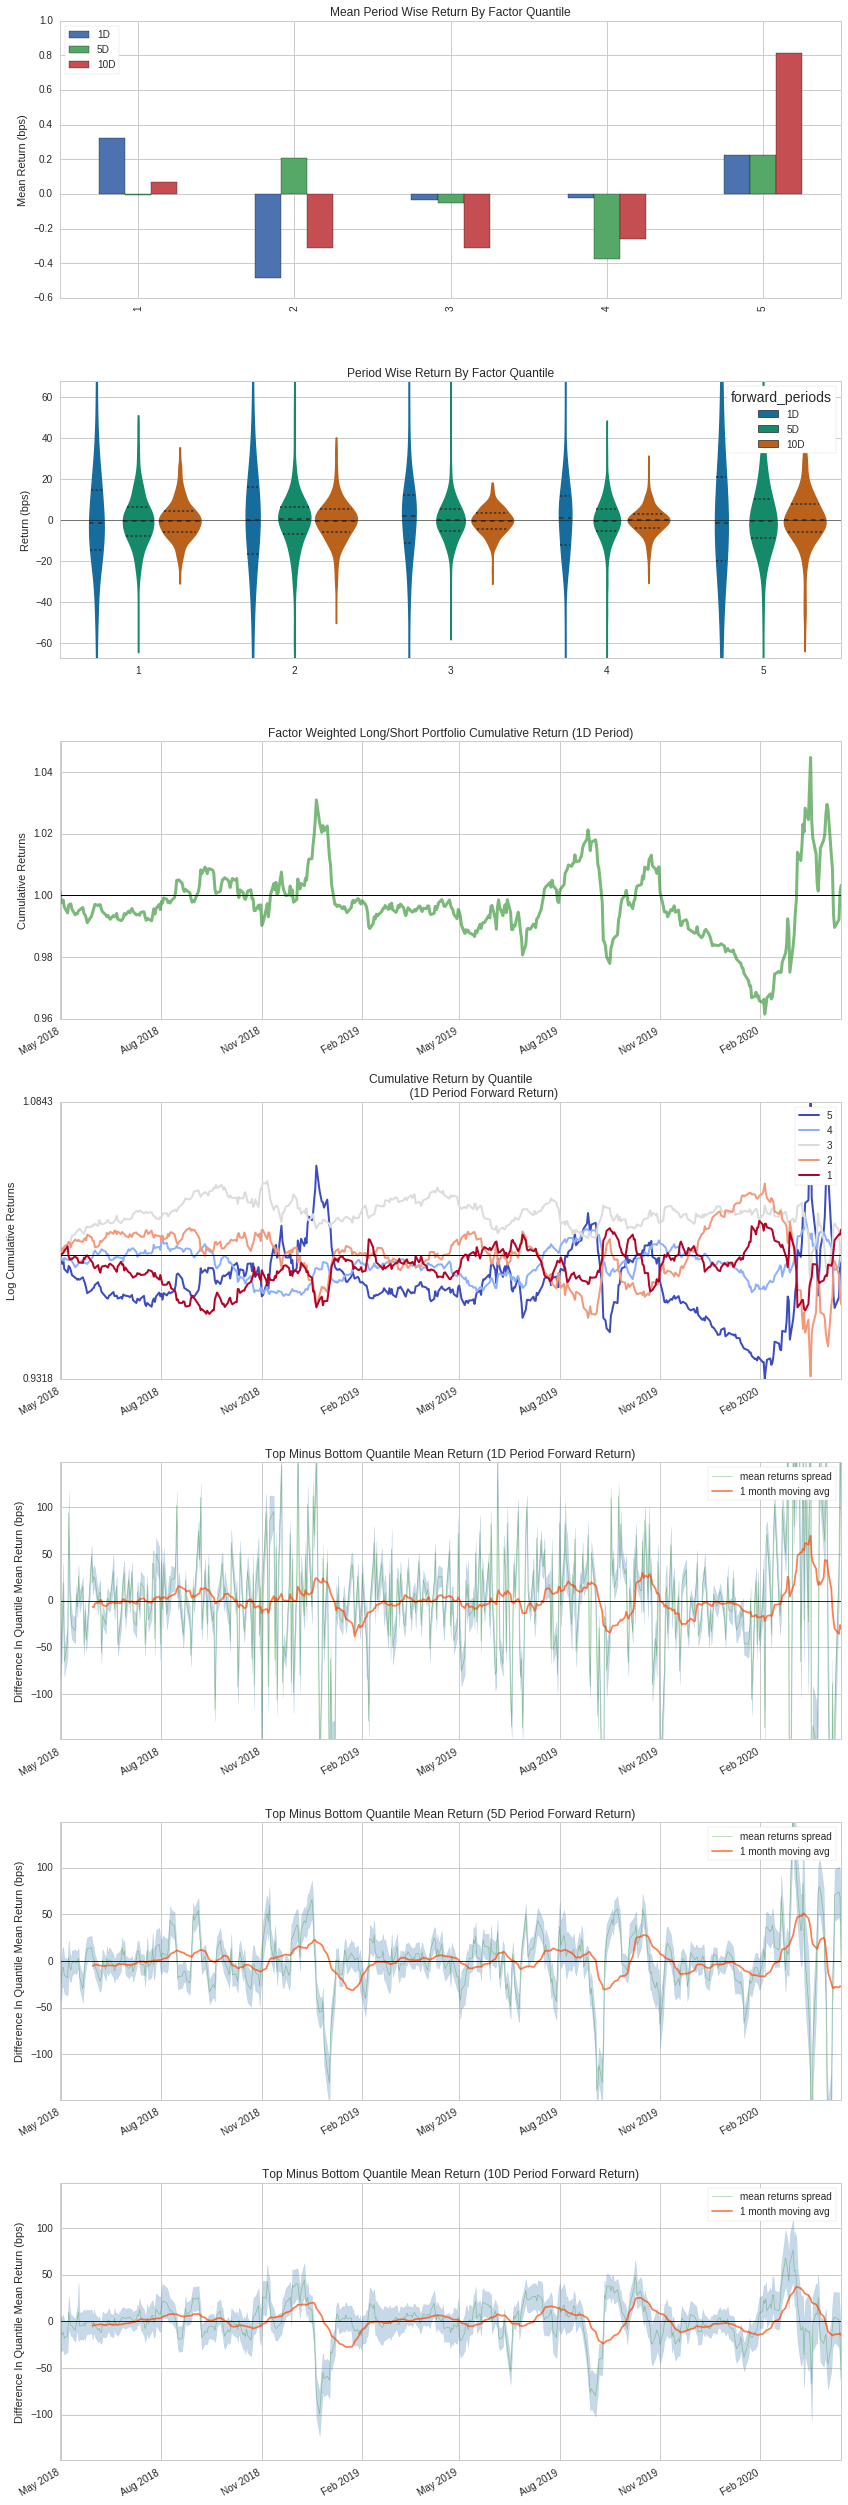

Information Analysis


,1D,5D,10D
IC Mean,0.004,0.007,0.011
IC Std.,0.099,0.105,0.106
Risk-Adjusted IC,0.041,0.064,0.105
t-stat(IC),0.916,1.428,2.337
p-value(IC),0.360,0.154,0.020
IC Skew,-0.273,-0.415,-0.460
IC Kurtosis,0.785,1.163,1.450


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


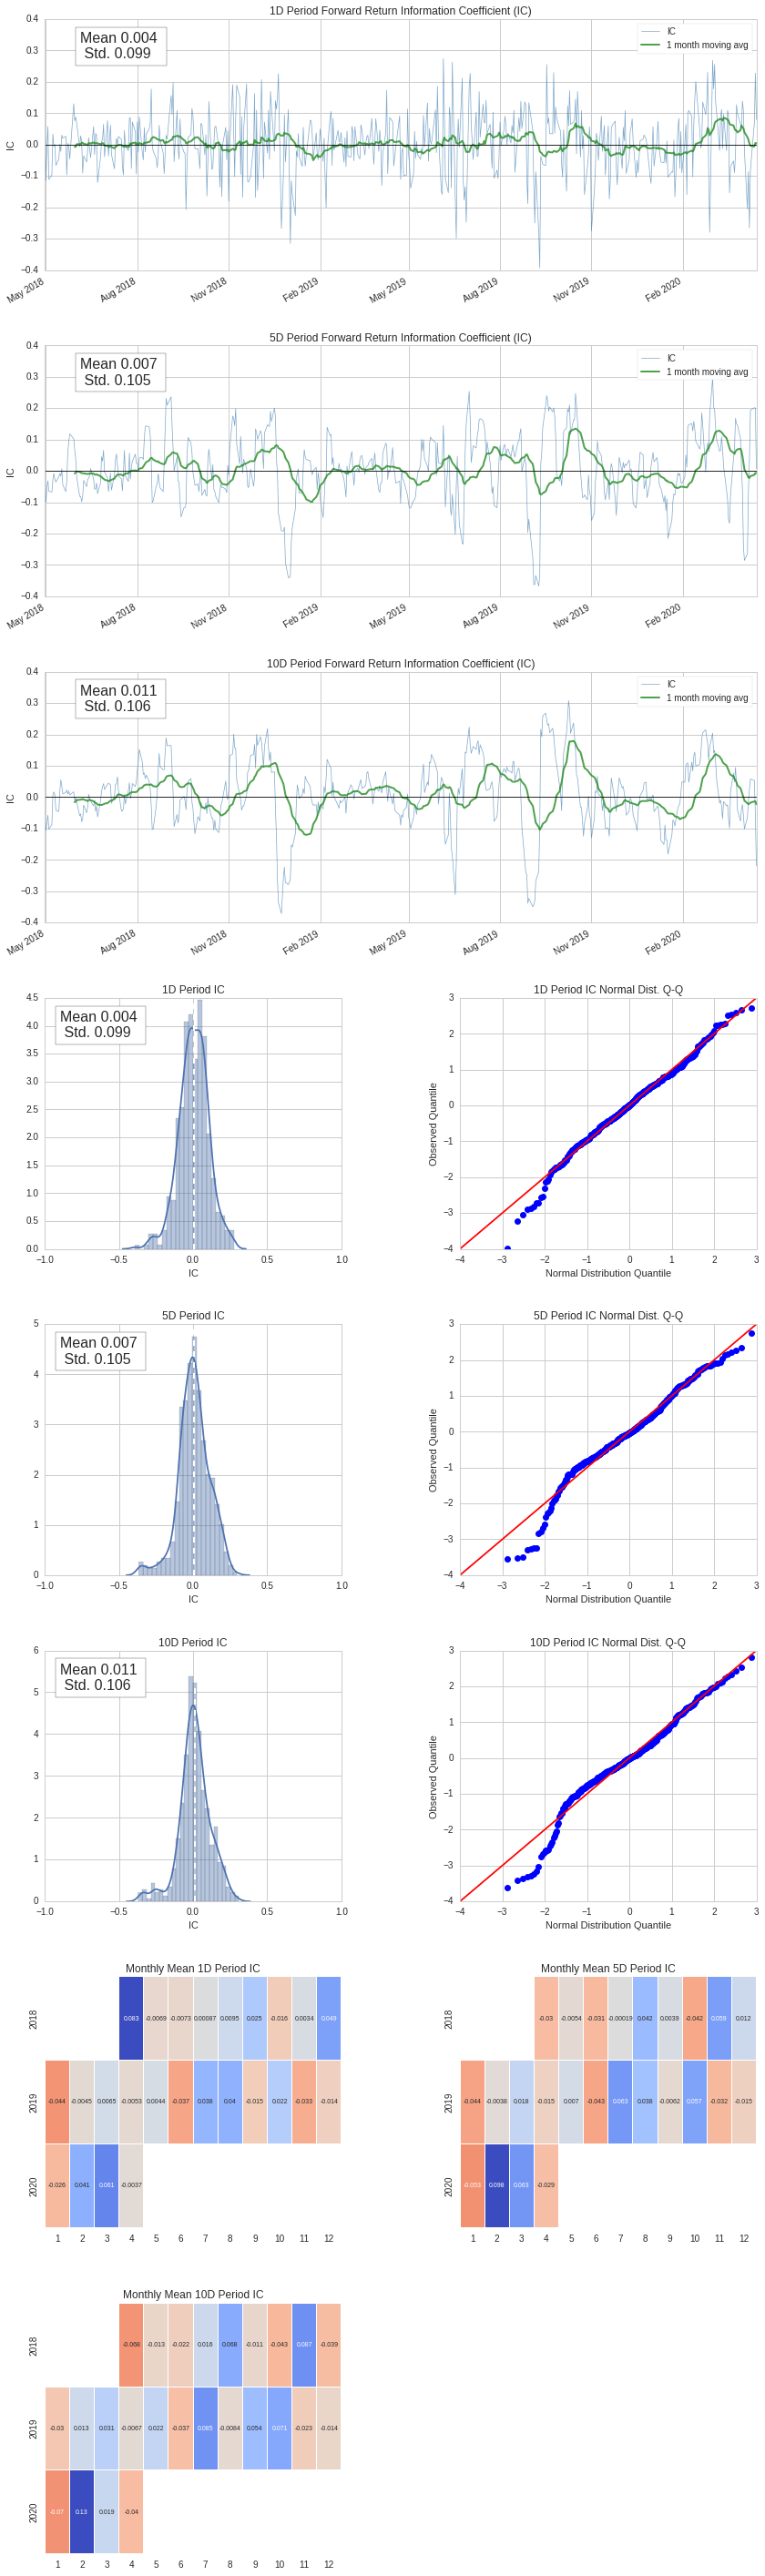

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.217,0.467,0.547
Quantile 2 Mean Turnover,0.422,0.654,0.705
Quantile 3 Mean Turnover,0.468,0.685,0.734
Quantile 4 Mean Turnover,0.430,0.656,0.705
Quantile 5 Mean Turnover,0.219,0.462,0.534


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.882,0.589,0.498


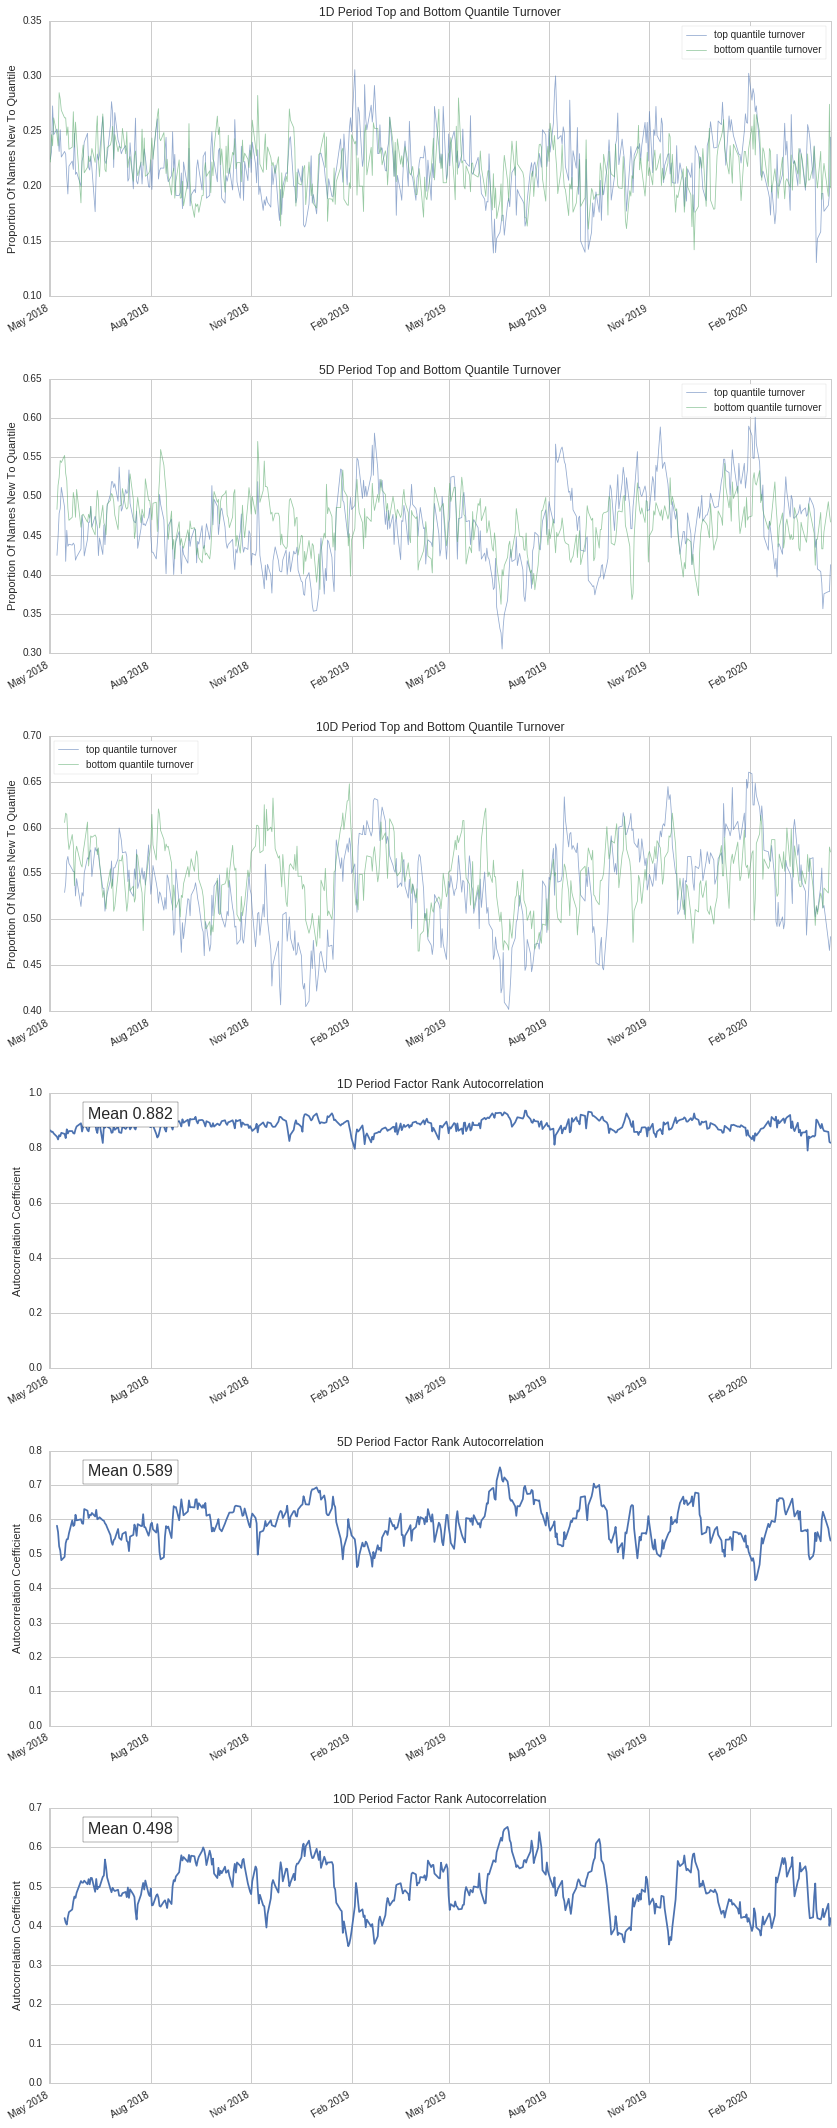

In [7]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(factor_data)

## That's It!

In the next lesson, we will show you how to interpret the charts produced by `create_full_tear_sheet()`.